## CUSTOMER SEGMENTATION

Firstly, declaring necessary libraries

In [298]:
# for data analysis
import pandas as pd
import numpy as np

import json     # for reading the key inside the json formatted file

# for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

import pyodbc   # for connecting database

In [299]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

> Connecting to Database

Pyodbc library handles the connection between Jupyter notebook and MS SQL Server. SQL Server's key is hidden inside the json file.

In [300]:
f = open('log.json')
sql_key = json.load(f)     # returns JSON object as a dictionary

cnxn = pyodbc.connect(sql_key['key'])     # establish a connection
crsr = cnxn.cursor()                      # cursor enables to send command

> Sending Queries 

Queries are sent with respect to the decisions given on analytics phase. G and T type company data are retrieved separately.

>> For G (Şahıs)

**bk_data** table is derived by using **dataset** table on MS SQL. It has been derived using a script which is available below.

In [301]:
gk_query= """SELECT ID, MUSTERI_ID, SIRKET_TURU,
            CEK_NO, CEK_TUTAR, KULLANDIRIM, SUBE, KESIDECI_ID, ISLEM_TARIHI,
            BK_KURUMSAYISI, BK_LIMIT, BK_RISK, BK_GECIKMEHESAP, BK_GECIKMEBAKIYE
            FROM dataset
            WHERE SIRKET_TURU='G' """
g_company_type_df = pd.read_sql(gk_query, cnxn)

In [302]:
g_company_type_df.head(10)

,ID,MUSTERI_ID,SIRKET_TURU,CEK_NO,CEK_TUTAR,KULLANDIRIM,SUBE,KESIDECI_ID,ISLEM_TARIHI,BK_KURUMSAYISI,BK_LIMIT,BK_RISK,BK_GECIKMEHESAP,BK_GECIKMEBAKIYE
0,2457932,11800527,G,70331933,20000.0,KY,PENDIK,11535476,2018-11-30,0,0,0,0,0
1,2457933,12024009,G,3014103,25000.0,KV,ÇORLU,11753282,2018-11-30,3,2213,226,2,1012
2,2457934,11800527,G,7031933,20000.0,KV,PENDIK,11535476,2018-11-30,0,0,0,0,0
3,2457936,11724283,G,7198012,23000.0,KY,TOPÇULAR,126553,2018-11-30,2,52100,9481,3,3575
4,2457937,11879266,G,9090937,10000.0,KY,ADANA,98511,2018-11-30,7,280101,211301,3,4128
5,2457938,11879266,G,9090936,13458.0,KY,ADANA,98511,2018-11-30,7,280101,211301,3,4128
6,2457939,11854083,G,4535918,5200.0,KY,IZMIT,12054732,2018-11-30,0,0,0,0,0
7,2457942,11654711,G,88624,110000.0,KY,BESEVLER,74198,2018-11-30,4,215261,150619,1,847
8,2457943,11723432,G,3331313,5300.0,KY,YILDIRIM,11570468,2018-11-30,4,104384,65599,3,2591
9,2457944,11577211,G,4602258,11000.0,KY,BEYLIKDÜZÜ,12054730,2018-11-30,4,215860,85589,4,6379


>> For T (Tüzel)

In [303]:
#tk_query= """SELECT MUSTERI_ID, ID, CEK_NO, CEK_TUTAR, VADE_GUN, TK_NAKDILIMIT, TK_NAKDIRISK, TK_GAYRINAKDILIMIT, TK_GAYRINAKDIRISK, TK_GECIKMEHESAP,TK_GECIKMEBAKIYE, TK_KURUMSAYISI, T2_NAKDILIMIT_TPL ,T2_NAKDIRISK_TPL ,T2_NAKDIRISK_KV ,T2_NAKDIRISK_OV ,T2_NAKDIRISK_UV,T2_GAYRINAKDILIMIT, T2_GAYRINAKDIRISK ,T2_FKTRNG_LIMIT ,T2_FKTRNG_TPLRISK ,T2_SORUNLUKOD_RISK, T3_NAKDILIMIT_TPL,T3_NAKDIRISK_TPL,T3_NAKDIRISK_KV,T3_NAKDIRISK_OV,T3_NAKDIRISK_UV,T3_GAYRINAKDILIMIT,T3_GAYRINAKDIRISK,T3_FKTRNG_LIMIT,T3_FKTRNG_TPLRISK,T3_SORUNLUKOD_RISK,T4_NAKDILIMIT_TPL,T4_NAKDIRISK_TPL,T4_NAKDIRISK_KV,T4_NAKDIRISK_OV,T4_NAKDIRISK_UV,T4_GAYRINAKDILIMIT,T4_GAYRINAKDIRISK,T4_FKTRNG_LIMIT,T4_FKTRNG_TPLRISK ,T4_SORUNLUKOD_RISKFROM dbo.dataset WHERE SIRKET_TURU LIKE 'T' """
#t_company_type_df = pd.read_sql(tk_query, cnxn)

> Handle Data Types *-for G type Customers*

For G type Customers, a new empty table is created as **bk_data** on the database. Then, G type customers' records are committed into the table using the following script. The code snippet is commented because we do not need to execute it again. The table is already committed successfully.

Firstly, we have to assign data types before ML operations

In [304]:
g_company_type_df.info()    # to see the data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229538 entries, 0 to 229537
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                229538 non-null  int64  
 1   MUSTERI_ID        229538 non-null  object 
 2   SIRKET_TURU       229538 non-null  object 
 3   CEK_NO            229538 non-null  object 
 4   CEK_TUTAR         229538 non-null  float64
 5   KULLANDIRIM       229538 non-null  object 
 6   SUBE              229538 non-null  object 
 7   KESIDECI_ID       229538 non-null  object 
 8   ISLEM_TARIHI      229538 non-null  object 
 9   BK_KURUMSAYISI    229538 non-null  int64  
 10  BK_LIMIT          229538 non-null  int64  
 11  BK_RISK           229538 non-null  int64  
 12  BK_GECIKMEHESAP   229538 non-null  int64  
 13  BK_GECIKMEBAKIYE  229538 non-null  object 
dtypes: float64(1), int64(5), object(8)
memory usage: 24.5+ MB


In [305]:
g_company_type_df['ID']=g_company_type_df['ID'].astype(int)

# converting into float to use on ML model later
g_company_type_df['BK_LIMIT']=g_company_type_df['BK_LIMIT'].astype(float)
g_company_type_df['BK_RISK']=g_company_type_df['BK_RISK'].astype(float)
g_company_type_df['BK_GECIKMEHESAP']=g_company_type_df['BK_GECIKMEHESAP'].astype(float)
g_company_type_df['BK_GECIKMEBAKIYE']=g_company_type_df['BK_GECIKMEBAKIYE'].astype(float)


Updated non-numeric values on *MUSTERI_ID*

In [306]:
"""UPDATE dataset
SET MUSTERI_ID = REPLACE(MUSTERI_ID, 'KD', '3')
WHERE MUSTERI_ID IS NOT NULL;

UPDATE dataset
SET MUSTERI_ID = REPLACE(MUSTERI_ID, 'SC', '')
WHERE MUSTERI_ID IS NOT NULL;

UPDATE dataset
SET MUSTERI_ID = REPLACE(MUSTERI_ID, 'KF', '1')
WHERE MUSTERI_ID IS NOT NULL;

UPDATE dataset
SET MUSTERI_ID = REPLACE(MUSTERI_ID, 'BC', '4')
WHERE MUSTERI_ID IS NOT NULL;

UPDATE dataset
SET MUSTERI_ID = REPLACE(MUSTERI_ID, 'AF', '5')
WHERE MUSTERI_ID IS NOT NULL;

SELECT MUSTERI_ID FROM dataset
WHERE ISNUMERIC(MUSTERI_ID)<> 1"""

"UPDATE dataset\nSET MUSTERI_ID = REPLACE(MUSTERI_ID, 'KD', '3')\nWHERE MUSTERI_ID IS NOT NULL;\n\nUPDATE dataset\nSET MUSTERI_ID = REPLACE(MUSTERI_ID, 'SC', '')\nWHERE MUSTERI_ID IS NOT NULL;\n\nUPDATE dataset\nSET MUSTERI_ID = REPLACE(MUSTERI_ID, 'KF', '1')\nWHERE MUSTERI_ID IS NOT NULL;\n\nUPDATE dataset\nSET MUSTERI_ID = REPLACE(MUSTERI_ID, 'BC', '4')\nWHERE MUSTERI_ID IS NOT NULL;\n\nUPDATE dataset\nSET MUSTERI_ID = REPLACE(MUSTERI_ID, 'AF', '5')\nWHERE MUSTERI_ID IS NOT NULL;\n\nSELECT MUSTERI_ID FROM dataset\nWHERE ISNUMERIC(MUSTERI_ID)<> 1"

In [307]:
# after performing query, can directly convert into int dtype
g_company_type_df['MUSTERI_ID']=g_company_type_df['MUSTERI_ID'].astype(int)


*CEK_NO* has several improper values, so we need to handle errors and convert it into integer

In [308]:
# used these queries to spot the non-integer values
"""SELECT [CEK_NO]
FROM [faktoring_db].[dbo].[dataset]
WHERE CEK_NO like '%[^a-Z0-9]%'

SELECT CEK_NO, COUNT(*) as count
FROM [faktoring_db].[dbo].[dataset]
WHERE CEK_NO like '%[^a-Z0-9]%'
GROUP BY CEK_NO
HAVING COUNT(*) > 0

//OR USE THIS, MORE EFFICIENT RESULTS

SELECT [ID],[CEK_NO]
FROM [faktoring_db].[dbo].[dataset]
WHERE ISNUMERIC([CEK_NO]) <> 1;"""

"SELECT [CEK_NO]\nFROM [faktoring_db].[dbo].[dataset]\nWHERE CEK_NO like '%[^a-Z0-9]%'\n\nSELECT CEK_NO, COUNT(*) as count\nFROM [faktoring_db].[dbo].[dataset]\nWHERE CEK_NO like '%[^a-Z0-9]%'\nGROUP BY CEK_NO\nHAVING COUNT(*) > 0\n\n//OR USE THIS, MORE EFFICIENT RESULTS\n\nSELECT [ID],[CEK_NO]\nFROM [faktoring_db].[dbo].[dataset]\nWHERE ISNUMERIC([CEK_NO]) <> 1;"

Solved the issue on MS SQL with the following script below:

In [309]:
#...and solved the issue by using the following queries
"""
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 1
WHERE [ID] = 2770334;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 2
WHERE [ID] = 2494076;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 3
WHERE [ID] = 2501347;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 4
WHERE [ID] = 2551433;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 5
WHERE [ID] = 2551434;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 6
WHERE [ID] = 2633345;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 7
WHERE [ID] = 2689531;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 8
WHERE [ID] = 2699745;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 9
WHERE [ID] = 2703751;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 10
WHERE [ID] = 2715934;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 11
WHERE [ID] = 2828009;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 12
WHERE [ID] = 2828010;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 13
WHERE [ID] = 2828011;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 14
WHERE [ID] = 2828012;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 15
WHERE [ID] = 2828013;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 16
WHERE [ID] = 2516070 OR
	[ID] = 2525905 OR
	[ID] = 2573048 OR
	[ID] = 2685207 OR
	[ID] = 2727249;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 17
WHERE [ID] = 2741161;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 18
WHERE [ID] = 2766289;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 19
WHERE [ID] = 2809942;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 20
WHERE [ID] = 2815551;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 21
WHERE [ID] = 2850473;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 22
WHERE [ID] = 2911050;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 23
WHERE [ID] = 2912888;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 24
WHERE [ID] = 2912889;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 25
WHERE [ID] = 2922915;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 26
WHERE [ID] = 2922916;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 27
WHERE [ID] = 2923795;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 28
WHERE [ID] = 2703536;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 29
WHERE [ID] = 2740283;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 30
WHERE [ID] = 2622979;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 31
WHERE [ID] = 2740284;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 32
WHERE [ID] = 2740285;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 33
WHERE [ID] = 2740286;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 34
WHERE [ID] = 2740287;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 35
WHERE [ID] = 2740288;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 36
WHERE [ID] = 2740289;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 37
WHERE [ID] = 2740290;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 38
WHERE [ID] = 2780745;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 39
WHERE [ID] = 2782835;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 40
WHERE [ID] = 2782836;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 41
WHERE [ID] = 2823409;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 42
WHERE [ID] = 2823497;
"""

'\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 1\nWHERE [ID] = 2770334;\n\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 2\nWHERE [ID] = 2494076;\n\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 3\nWHERE [ID] = 2501347;\n\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 4\nWHERE [ID] = 2551433;\n\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 5\nWHERE [ID] = 2551434;\n\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 6\nWHERE [ID] = 2633345;\n\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 7\nWHERE [ID] = 2689531;\n\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 8\nWHERE [ID] = 2699745;\n\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 9\nWHERE [ID] = 2703751;\n\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 10\nWHERE [ID] = 2715934;\n\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 11\nWHERE [ID] = 2828009;\n\nUPDATE [faktoring_db].[dbo].[dataset]\nSET [CEK_NO] = 12\nWHERE [ID] = 2828010;\n\nUPDATE [fa

In [310]:
# finally, the script is executed successfully
g_company_type_df['CEK_NO']=g_company_type_df['CEK_NO'].astype('int64')

In [311]:
g_company_type_df['KESIDECI_ID'] = g_company_type_df['KESIDECI_ID'].str.extract('(\d+)', expand=False).astype('int')

g_company_type_df['SIRKET_TURU'] = g_company_type_df['SIRKET_TURU'].astype('string')
g_company_type_df['SUBE'] = g_company_type_df['SUBE'].astype('string')
g_company_type_df['KULLANDIRIM'] = g_company_type_df['KULLANDIRIM'].astype('string')

g_company_type_df['CEK_TUTAR'] = g_company_type_df['CEK_TUTAR'].replace(',','.', regex=True).astype('float')
g_company_type_df['BK_KURUMSAYISI'] = g_company_type_df['BK_KURUMSAYISI'].astype('int')

g_company_type_df['ISLEM_TARIHI'] = pd.to_datetime(g_company_type_df['ISLEM_TARIHI'], format='%Y.%m.%d')

In [312]:
#to see the data types after the changes
g_company_type_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229538 entries, 0 to 229537
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ID                229538 non-null  int32         
 1   MUSTERI_ID        229538 non-null  int32         
 2   SIRKET_TURU       229538 non-null  string        
 3   CEK_NO            229538 non-null  int64         
 4   CEK_TUTAR         229538 non-null  float64       
 5   KULLANDIRIM       229538 non-null  string        
 6   SUBE              229538 non-null  string        
 7   KESIDECI_ID       229538 non-null  int32         
 8   ISLEM_TARIHI      229538 non-null  datetime64[ns]
 9   BK_KURUMSAYISI    229538 non-null  int32         
 10  BK_LIMIT          229538 non-null  float64       
 11  BK_RISK           229538 non-null  float64       
 12  BK_GECIKMEHESAP   229538 non-null  float64       
 13  BK_GECIKMEBAKIYE  229538 non-null  float64       
dtypes: d

In [313]:
g_company_type_df['MUSTERI_ID']=g_company_type_df['MUSTERI_ID'].astype('int64')
g_company_type_df['ID']=g_company_type_df['ID'].astype('int64')

> Feature Extraction

Deriving new attributes using the existing ones provides us to generate new features and find insight into data. 


Firstly, exploring the attribute.

In [314]:
g_company_type_df[(g_company_type_df['BK_RISK'] != 0) & (g_company_type_df['BK_LIMIT'] == 0)]   # obtaining the case of RISK is not 0 but LIMIT is 0
g_company_type_df[(g_company_type_df['BK_RISK'] == 0) & (g_company_type_df['BK_LIMIT'] != 0)]   # obtaining the case of RISK is 0 but LIMIT is not 0

,ID,MUSTERI_ID,SIRKET_TURU,CEK_NO,CEK_TUTAR,KULLANDIRIM,SUBE,KESIDECI_ID,ISLEM_TARIHI,BK_KURUMSAYISI,BK_LIMIT,BK_RISK,BK_GECIKMEHESAP,BK_GECIKMEBAKIYE
12,2457952,11860577,G,1023231,12605.490234,KY,KAYSERI,134618,2018-11-30,1,1000.0,0.0,0.0,0.0
87,2458126,11884594,G,381633,15000.000000,KY,ISKENDERUN,30052,2018-11-30,2,5200.0,0.0,1.0,296.0
144,2458237,11793964,G,3167451,9500.000000,KV,KARABAGLAR,11992164,2018-11-30,1,750.0,0.0,0.0,0.0
168,2458278,11593517,G,271555,50000.000000,KY,DUDULLU,11592311,2018-11-30,1,550.0,0.0,1.0,35.0
177,2458290,11506837,G,8060375,23100.000000,KY,ANTALYA,11952661,2018-11-30,1,500.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229377,2939494,11620749,G,1614282,30000.000000,KY,MECIDIYEKÖY,104996,2018-01-02,2,3000.0,0.0,0.0,0.0
229379,2939497,11855859,G,12927,30000.000000,KV,MERSIN,11908808,2018-01-02,1,750.0,0.0,0.0,0.0
229400,2939551,124816,G,694134,5000.000000,KY,ESKISEHIR,69677,2018-01-02,2,1550.0,0.0,3.0,522.0
229401,2939552,124816,G,694133,5000.000000,KY,ESKISEHIR,69677,2018-01-02,2,1550.0,0.0,3.0,522.0


As seen, there are several cases on the dataframe that one of those attribute is zero while other is not.

We must create a new attribute called **BK_ORAN** which is ***derived by diving BK_RISK to BK_LIMIT***. It will represent as higher ratio provides higher reliability on the customer check payback

*Meanwhile, must be aware of the cases where one of those attributes is equal to 0 and the other is not 0!*

In [315]:
g_company_type_df['BK_ORAN'] = 0    # creating a new column for BK_ORAN and initializing it with 0

# for cases of RISK and LIMIT both are not equal to 0, BK_ORAN is calculated as a ratio of LIMIT to RISK
mask = (g_company_type_df['BK_RISK'] != 0) & (g_company_type_df['BK_LIMIT'] != 0)
g_company_type_df.loc[mask, 'BK_ORAN'] = g_company_type_df.loc[mask, 'BK_LIMIT'] / g_company_type_df.loc[mask, 'BK_RISK']

# for cases of RISK is equal to 0 but LIMIT is not 0, BK_ORAN is calculated as LIMIT / 0.1
mask = (g_company_type_df['BK_RISK'] == 0) & (g_company_type_df['BK_LIMIT'] != 0)
g_company_type_df.loc[mask, 'BK_ORAN'] = g_company_type_df.loc[mask, 'BK_LIMIT'] / 0.1  # assigning the value of RISK as 0.1 instead of 0

# for cases of RISK is not 0 and LIMIT is equal to 0, BK_ORAN is calculated as 0.1 / RISK
mask = (g_company_type_df['BK_LIMIT'] == 0) & (g_company_type_df['BK_RISK'] != 0)
g_company_type_df.loc[mask, 'BK_ORAN'] = 0.1 / g_company_type_df.loc[mask, 'BK_RISK']   # assigning the value of LIMIT as 0.1 instead of 0

mask = (g_company_type_df['BK_LIMIT'] == 0) & (g_company_type_df['BK_RISK'] == 0)
g_company_type_df.loc[mask, 'BK_ORAN'] = 0


The feature extraction is also already committed on the database, so comment this code snippet.

In [316]:
g_company_type_df['BK_ORAN'].describe()                                                     # to see the statistical summary of the data

count    229538.000000
mean        991.941698
std       13452.459457
min           0.000000
25%           1.105593
50%           1.381565
75%           1.936203
max      879000.000000
Name: BK_ORAN, dtype: float64

Another feature extraction will be created below. **Count number of KESIDECI_ID for each customer**

In [317]:
# how to count the number of unique KESIDECI_ID for each CUSTOMER_ID
g_company_type_df.groupby('MUSTERI_ID')['KESIDECI_ID'].nunique().sort_values(ascending=False)

MUSTERI_ID
11633272     115
11529385     111
11954204     101
74805         97
28987         93
            ... 
11848956       1
11848938       1
11848905       1
11848611       1
300188452      1
Name: KESIDECI_ID, Length: 38374, dtype: int64

In [318]:
count_kesideci_df = g_company_type_df.groupby('MUSTERI_ID')['KESIDECI_ID'].nunique().reset_index()
count_kesideci_df.columns = ['MUSTERI_ID', 'KESIDECI_COUNT']

g_company_type_df = pd.merge(g_company_type_df, count_kesideci_df, on='MUSTERI_ID', how='left')     # left outer join to append KESIDECI_ID count per customers
del count_kesideci_df # delete the temporary dataframe

In [319]:
g_company_type_df.head(5)

,ID,MUSTERI_ID,SIRKET_TURU,CEK_NO,CEK_TUTAR,KULLANDIRIM,SUBE,KESIDECI_ID,ISLEM_TARIHI,BK_KURUMSAYISI,BK_LIMIT,BK_RISK,BK_GECIKMEHESAP,BK_GECIKMEBAKIYE,BK_ORAN,KESIDECI_COUNT
0,2457932,11800527,G,70331933,20000.0,KY,PENDIK,11535476,2018-11-30,0,0.0,0.0,0.0,0.0,0.000000,3
1,2457933,12024009,G,3014103,25000.0,KV,ÇORLU,11753282,2018-11-30,3,2213.0,226.0,2.0,1012.0,9.792035,4
2,2457934,11800527,G,7031933,20000.0,KV,PENDIK,11535476,2018-11-30,0,0.0,0.0,0.0,0.0,0.000000,3
3,2457936,11724283,G,7198012,23000.0,KY,TOPÇULAR,126553,2018-11-30,2,52100.0,9481.0,3.0,3575.0,5.495201,4
4,2457937,11879266,G,9090937,10000.0,KY,ADANA,98511,2018-11-30,7,280101.0,211301.0,3.0,4128.0,1.325602,4


**Count number of different SUBE for each customer**

In [320]:
# how to count the number of unique KESIDECI_ID for each CUSTOMER_ID
g_company_type_df.groupby('MUSTERI_ID')['SUBE'].nunique().sort_values(ascending=False)

MUSTERI_ID
11635461     4
11729006     3
11937686     3
11870207     3
11919651     3
            ..
11720582     1
11720587     1
11720594     1
11720639     1
300188452    1
Name: SUBE, Length: 38374, dtype: int64

In [321]:
count_sube_df = g_company_type_df.groupby('MUSTERI_ID')['SUBE'].nunique().reset_index()
count_sube_df.columns = ['MUSTERI_ID', 'SUBE_COUNT']

g_company_type_df = pd.merge(g_company_type_df, count_sube_df, on='MUSTERI_ID', how='left')     # left outer join to append SUBE count per customers
del count_sube_df                                                                               # delete the temporary dataframe

In [322]:
g_company_type_df.head(5)

,ID,MUSTERI_ID,SIRKET_TURU,CEK_NO,CEK_TUTAR,KULLANDIRIM,SUBE,KESIDECI_ID,ISLEM_TARIHI,BK_KURUMSAYISI,BK_LIMIT,BK_RISK,BK_GECIKMEHESAP,BK_GECIKMEBAKIYE,BK_ORAN,KESIDECI_COUNT,SUBE_COUNT
0,2457932,11800527,G,70331933,20000.0,KY,PENDIK,11535476,2018-11-30,0,0.0,0.0,0.0,0.0,0.000000,3,2
1,2457933,12024009,G,3014103,25000.0,KV,ÇORLU,11753282,2018-11-30,3,2213.0,226.0,2.0,1012.0,9.792035,4,1
2,2457934,11800527,G,7031933,20000.0,KV,PENDIK,11535476,2018-11-30,0,0.0,0.0,0.0,0.0,0.000000,3,2
3,2457936,11724283,G,7198012,23000.0,KY,TOPÇULAR,126553,2018-11-30,2,52100.0,9481.0,3.0,3575.0,5.495201,4,1
4,2457937,11879266,G,9090937,10000.0,KY,ADANA,98511,2018-11-30,7,280101.0,211301.0,3.0,4128.0,1.325602,4,1


The customers get income from check which KULLANDIRIM is equal to KV. **Sum the CEK_TUTAR** for each customer using this case.

In [323]:
# how to sum the CEK_TUTAR amount for each CUSTOMER_ID where KULLANDIRIM is equal to KV
g_company_type_df[g_company_type_df['KULLANDIRIM'] == 'KV'].groupby('MUSTERI_ID')['CEK_TUTAR'].sum().sort_values(ascending=False)

MUSTERI_ID
11633272    1.218740e+06
11662188    1.101993e+06
11688660    1.005800e+06
131702      9.089248e+05
28648       8.152050e+05
                ...     
12034143    1.600000e+03
136012      1.509000e+03
11956149    1.500000e+03
11869377    1.500000e+03
11701463    1.422610e+03
Name: CEK_TUTAR, Length: 19219, dtype: float64

In [324]:
sum_cekTutar_df = g_company_type_df[g_company_type_df['KULLANDIRIM'] == 'KV'].groupby('MUSTERI_ID')['CEK_TUTAR'].sum().reset_index()
sum_cekTutar_df.columns = ['MUSTERI_ID', 'CEK_INCOME']

g_company_type_df = pd.merge(g_company_type_df, sum_cekTutar_df, on='MUSTERI_ID', how='left')     # left outer join to append KESIDECI_ID count per customers
del sum_cekTutar_df                                                                               # delete the temporary dataframe

g_company_type_df['CEK_INCOME'].fillna(0, inplace=True)                                           # fill the NaN values with 0

In [325]:
g_company_type_df.head(5)

,ID,MUSTERI_ID,SIRKET_TURU,CEK_NO,CEK_TUTAR,KULLANDIRIM,SUBE,KESIDECI_ID,ISLEM_TARIHI,BK_KURUMSAYISI,BK_LIMIT,BK_RISK,BK_GECIKMEHESAP,BK_GECIKMEBAKIYE,BK_ORAN,KESIDECI_COUNT,SUBE_COUNT,CEK_INCOME
0,2457932,11800527,G,70331933,20000.0,KY,PENDIK,11535476,2018-11-30,0,0.0,0.0,0.0,0.0,0.000000,3,2,50500.0
1,2457933,12024009,G,3014103,25000.0,KV,ÇORLU,11753282,2018-11-30,3,2213.0,226.0,2.0,1012.0,9.792035,4,1,50000.0
2,2457934,11800527,G,7031933,20000.0,KV,PENDIK,11535476,2018-11-30,0,0.0,0.0,0.0,0.0,0.000000,3,2,50500.0
3,2457936,11724283,G,7198012,23000.0,KY,TOPÇULAR,126553,2018-11-30,2,52100.0,9481.0,3.0,3575.0,5.495201,4,1,168000.0
4,2457937,11879266,G,9090937,10000.0,KY,ADANA,98511,2018-11-30,7,280101.0,211301.0,3.0,4128.0,1.325602,4,1,0.0


**Calculate the Frequency of Customer Check Transactions**

In [326]:
# to see the number of transactions in different dates by each customer
g_company_type_df.groupby('MUSTERI_ID')['ISLEM_TARIHI'].nunique().sort_values(ascending=True)

MUSTERI_ID
300188452      1
11982080       1
11982051       1
11982034       1
11754965       1
            ... 
11769908      81
11609912      82
11529385      84
11954204      86
11633272     100
Name: ISLEM_TARIHI, Length: 38374, dtype: int64

In [327]:
transact_date_sorted = g_company_type_df.sort_values(['MUSTERI_ID', 'ISLEM_TARIHI'])    # sort the data using new dataframe first

# Calculate the time difference between consecutive transactions for each customer
transact_date_sorted['DAYS_BETWEEN_TRANSACTIONS'] = transact_date_sorted.groupby('MUSTERI_ID')['ISLEM_TARIHI'].diff().dt.days
# Calculate the average days between transactions for each customer
transact_avg_days = transact_date_sorted.groupby('MUSTERI_ID')['DAYS_BETWEEN_TRANSACTIONS'].mean().reset_index(name='AVERAGE_DAYS')

transact_avg_days['AVERAGE_DAYS'].fillna(0, inplace=True)   # fill the NaN values with 0
g_company_type_df= g_company_type_df.merge(transact_avg_days, on='MUSTERI_ID', how='left')     # left outer join to append the feature extraction

In [328]:
g_company_type_df['AVERAGE_DAYS'].value_counts().sort_index(ascending=True)

0.000000      18164
0.076923         14
0.090909         12
0.111111         20
0.125000          9
              ...  
315.000000        2
316.000000        4
317.000000        2
325.000000        2
326.000000        2
Name: AVERAGE_DAYS, Length: 4197, dtype: int64

After assigning values, convert them into categories.

    0-30 days->Very Often Transactions
    30-90 days->Often Transactions
    90-360->Rare
    0->One timer Customer

In [329]:
# create categories by the conditions above for AVERAGE_DAYS
g_company_type_df['TRANSACTIONS_FREQ'] = pd.cut(g_company_type_df['AVERAGE_DAYS'], bins=[-1, 1, 30, 90, 360], labels=['One Timer', 'Very Often', 'Often', 'Rare'])

In [330]:
g_company_type_df['TRANSACTIONS_FREQ'].value_counts().sort_index(ascending=True)

One Timer      19968
Very Often    169228
Often          35423
Rare            4919
Name: TRANSACTIONS_FREQ, dtype: int64

We need to implement **one-hot encoding** to make this attribute feasible for ML operations

In [331]:
one_hot_encoded_freq = pd.get_dummies(g_company_type_df['TRANSACTIONS_FREQ'])       # one hot encoding for the new feature
g_company_type_df = pd.concat([g_company_type_df, one_hot_encoded_freq], axis=1)    # append the encodings as new features to the dataframe

We can delete based columns after deriving them by feature extractions

In [332]:
del g_company_type_df['KESIDECI_ID']    # delete the column KESIDECI_ID
del g_company_type_df['SUBE']           # delete the column SUBE
del g_company_type_df['KULLANDIRIM']    # delete the column KULLANDIRIM
del g_company_type_df['SIRKET_TURU']    # delete the column SIRKET_TURU
del g_company_type_df['CEK_TUTAR']      # delete the column CEK_TUTAR

del g_company_type_df['ISLEM_TARIHI']   # delete the column ISLEM_TARIHI
del g_company_type_df['AVERAGE_DAYS']   # delete the column AVERAGE_DAYS
del g_company_type_df['TRANSACTIONS_FREQ']   # delete the column TRANSACTIONS_FREQ

del g_company_type_df['BK_LIMIT']       # delete the column BK_LIMIT
del g_company_type_df['BK_RISK']        # delete the column BK_RISK
del g_company_type_df['CEK_NO']         # delete the column CEK_NO

In [333]:
g_company_type_df.describe()    # to see the statistical summary of the data

,ID,MUSTERI_ID,BK_KURUMSAYISI,BK_GECIKMEHESAP,BK_GECIKMEBAKIYE,BK_ORAN,KESIDECI_COUNT,SUBE_COUNT,CEK_INCOME,One Timer,Very Often,Often,Rare
count,2.295380e+05,2.295380e+05,229538.000000,229538.000000,2.295380e+05,229538.000000,229538.000000,229538.000000,2.295380e+05,229538.000000,229538.000000,229538.000000,229538.000000
mean,2.701168e+06,1.035900e+07,3.123295,1.928814,2.203242e+03,991.941698,11.707125,1.017696,9.879701e+04,0.086992,0.737255,0.154323,0.021430
std,1.395355e+05,1.378615e+07,2.247007,2.176905,1.856836e+04,13452.459457,13.903977,0.134041,1.170346e+05,0.281824,0.440126,0.361259,0.144813
min,2.457932e+06,1.050000e+02,0.000000,0.000000,0.000000e+00,0.000000,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,2.580292e+06,1.157614e+07,1.000000,0.000000,0.000000e+00,1.105593,3.000000,1.000000,1.500000e+04,0.000000,0.000000,0.000000,0.000000
50%,2.702264e+06,1.176364e+07,3.000000,1.000000,4.710000e+02,1.381565,7.000000,1.000000,6.200000e+04,0.000000,1.000000,0.000000,0.000000
75%,2.822914e+06,1.190118e+07,4.000000,3.000000,2.381000e+03,1.936203,15.000000,1.000000,1.460394e+05,0.000000,1.000000,0.000000,0.000000
max,2.939795e+06,3.001885e+08,15.000000,31.000000,2.384798e+06,879000.000000,115.000000,4.000000,1.218740e+06,1.000000,1.000000,1.000000,1.000000


> Save Changes on Table to Database

In [334]:
g_company_type_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229538 entries, 0 to 229537
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                229538 non-null  int64  
 1   MUSTERI_ID        229538 non-null  int64  
 2   BK_KURUMSAYISI    229538 non-null  int32  
 3   BK_GECIKMEHESAP   229538 non-null  float64
 4   BK_GECIKMEBAKIYE  229538 non-null  float64
 5   BK_ORAN           229538 non-null  float64
 6   KESIDECI_COUNT    229538 non-null  int64  
 7   SUBE_COUNT        229538 non-null  int64  
 8   CEK_INCOME        229538 non-null  float64
 9   One Timer         229538 non-null  uint8  
 10  Very Often        229538 non-null  uint8  
 11  Often             229538 non-null  uint8  
 12  Rare              229538 non-null  uint8  
dtypes: float64(4), int32(1), int64(4), uint8(4)
memory usage: 17.5 MB


In [335]:
#for index, row in g_company_type_df.iterrows():
#    crsr.execute("""INSERT INTO bk_data (ID, MUSTERI_ID, CEK_NO,BK_KURUMSAYISI, BK_LIMIT, BK_RISK, BK_GECIKMEHESAP, BK_GECIKMEBAKIYE, BK_ORAN, KESIDECI_COUNT, SUBE_COUNT, CEK_INCOME)VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)""",
#    row.ID, row.MUSTERI_ID, row.CEK_NO,row.BK_KURUMSAYISI, row.BK_LIMIT, row.BK_RISK, row.BK_GECIKMEHESAP, row.BK_GECIKMEBAKIYE, row.BK_ORAN,row.KESIDECI_COUNT, row.SUBE_COUNT, row.CEK_INCOME)
#cnxn.commit()
#crsr.close()


> Handle Data Types *-for T type Customers*

For T type Customers...

In [336]:
#t_company_type_df.head(5)

In [337]:
#t_company_type_df.info()

There are no null values according to info, but there are values written as "NULL", so we need to convert them into null values

In [338]:
#t_company_type_df = t_company_type_df.replace('NULL', None)

Then, assign their data type

In [339]:
"""t_company_type_df['T4_SORUNLUKOD_RISK'] = t_company_type_df['T4_SORUNLUKOD_RISK'].astype('float')
t_company_type_df['T4_FKTRNG_TPLRISK'] = t_company_type_df['T4_FKTRNG_TPLRISK'].astype('float')
t_company_type_df['T4_FKTRNG_LIMIT'] = t_company_type_df['T4_FKTRNG_LIMIT'].astype('float')
t_company_type_df['T4_GAYRINAKDIRISK'] = t_company_type_df['T4_GAYRINAKDIRISK'].astype('float')
t_company_type_df['T4_GAYRINAKDILIMIT'] = t_company_type_df['T4_GAYRINAKDILIMIT'].astype('float')
t_company_type_df['T4_NAKDIRISK_UV'] = t_company_type_df['T4_NAKDIRISK_UV'].astype('float')
t_company_type_df['T4_NAKDIRISK_OV'] = t_company_type_df['T4_NAKDIRISK_OV'].astype('float')
t_company_type_df['T4_NAKDIRISK_KV'] = t_company_type_df['T4_NAKDIRISK_KV'].astype('float')
t_company_type_df['T4_NAKDIRISK_TPL'] = t_company_type_df['T4_NAKDIRISK_TPL'].astype('float')
t_company_type_df['T4_NAKDILIMIT_TPL'] = t_company_type_df['T4_NAKDILIMIT_TPL'].astype('float')

t_company_type_df['T3_SORUNLUKOD_RISK'] = t_company_type_df['T3_SORUNLUKOD_RISK'].astype('float')
t_company_type_df['T3_FKTRNG_TPLRISK'] = t_company_type_df['T3_FKTRNG_TPLRISK'].astype('float')
t_company_type_df['T3_FKTRNG_LIMIT'] = t_company_type_df['T3_FKTRNG_LIMIT'].astype('float')
t_company_type_df['T3_GAYRINAKDIRISK'] = t_company_type_df['T3_GAYRINAKDIRISK'].astype('float')
t_company_type_df['T3_GAYRINAKDILIMIT'] = t_company_type_df['T3_GAYRINAKDILIMIT'].astype('float')
t_company_type_df['T3_NAKDIRISK_UV'] = t_company_type_df['T3_NAKDIRISK_UV'].astype('float')
t_company_type_df['T3_NAKDIRISK_OV'] = t_company_type_df['T3_NAKDIRISK_OV'].astype('float')
t_company_type_df['T3_NAKDIRISK_KV'] = t_company_type_df['T3_NAKDIRISK_KV'].astype('float')
t_company_type_df['T3_NAKDIRISK_TPL'] = t_company_type_df['T3_NAKDIRISK_TPL'].astype('float')
t_company_type_df['T3_NAKDILIMIT_TPL'] = t_company_type_df['T3_NAKDILIMIT_TPL'].astype('float')

t_company_type_df['T2_SORUNLUKOD_RISK'] = t_company_type_df['T2_SORUNLUKOD_RISK'].astype('float')
t_company_type_df['T2_FKTRNG_TPLRISK'] = t_company_type_df['T2_FKTRNG_TPLRISK'].astype('float')
t_company_type_df['T2_FKTRNG_LIMIT'] = t_company_type_df['T2_FKTRNG_LIMIT'].astype('float')
t_company_type_df['T2_GAYRINAKDIRISK'] = t_company_type_df['T2_GAYRINAKDIRISK'].astype('float')
t_company_type_df['T2_GAYRINAKDILIMIT'] = t_company_type_df['T2_GAYRINAKDILIMIT'].astype('float')
t_company_type_df['T2_NAKDIRISK_UV'] = t_company_type_df['T2_NAKDIRISK_UV'].astype('float')
t_company_type_df['T2_NAKDIRISK_OV'] = t_company_type_df['T2_NAKDIRISK_OV'].astype('float')
t_company_type_df['T2_NAKDIRISK_KV'] = t_company_type_df['T2_NAKDIRISK_KV'].astype('float')
t_company_type_df['T2_NAKDIRISK_TPL'] = t_company_type_df['T2_NAKDIRISK_TPL'].astype('float')
t_company_type_df['T2_NAKDILIMIT_TPL'] = t_company_type_df['T2_NAKDILIMIT_TPL'].astype('float')

t_company_type_df['TK_GAYRINAKDIRISK'] = t_company_type_df['TK_GAYRINAKDIRISK'].astype('float')
t_company_type_df['TK_GAYRINAKDILIMIT'] = t_company_type_df['TK_GAYRINAKDILIMIT'].astype('float')
t_company_type_df['TK_NAKDIRISK'] = t_company_type_df['TK_NAKDIRISK'].astype('float')
t_company_type_df['TK_NAKDILIMIT'] = t_company_type_df['TK_NAKDILIMIT'].astype('float')
t_company_type_df['TK_GECIKMEHESAP'] = t_company_type_df['TK_GECIKMEHESAP'].astype('float')
t_company_type_df['TK_GECIKMEBAKIYE'] = t_company_type_df['TK_GECIKMEBAKIYE'].astype('float')
t_company_type_df['TK_KURUMSAYISI'] = t_company_type_df['TK_KURUMSAYISI'].astype('int')
t_company_type_df['VADE_GUN'] = t_company_type_df['VADE_GUN'].astype('int')

t_company_type_df['CEK_NO'] = t_company_type_df['CEK_NO'].astype('int64')

t_company_type_df['MUSTERI_ID']= t_company_type_df['MUSTERI_ID'].str.replace(r'\D', '').astype(int)
t_company_type_df['MUSTERI_ID'] = t_company_type_df['MUSTERI_ID'].astype('int')

t_company_type_df['CEK_TUTAR'] = t_company_type_df['CEK_TUTAR'].replace(',','.', regex=True).astype('float')"""

"t_company_type_df['T4_SORUNLUKOD_RISK'] = t_company_type_df['T4_SORUNLUKOD_RISK'].astype('float')\nt_company_type_df['T4_FKTRNG_TPLRISK'] = t_company_type_df['T4_FKTRNG_TPLRISK'].astype('float')\nt_company_type_df['T4_FKTRNG_LIMIT'] = t_company_type_df['T4_FKTRNG_LIMIT'].astype('float')\nt_company_type_df['T4_GAYRINAKDIRISK'] = t_company_type_df['T4_GAYRINAKDIRISK'].astype('float')\nt_company_type_df['T4_GAYRINAKDILIMIT'] = t_company_type_df['T4_GAYRINAKDILIMIT'].astype('float')\nt_company_type_df['T4_NAKDIRISK_UV'] = t_company_type_df['T4_NAKDIRISK_UV'].astype('float')\nt_company_type_df['T4_NAKDIRISK_OV'] = t_company_type_df['T4_NAKDIRISK_OV'].astype('float')\nt_company_type_df['T4_NAKDIRISK_KV'] = t_company_type_df['T4_NAKDIRISK_KV'].astype('float')\nt_company_type_df['T4_NAKDIRISK_TPL'] = t_company_type_df['T4_NAKDIRISK_TPL'].astype('float')\nt_company_type_df['T4_NAKDILIMIT_TPL'] = t_company_type_df['T4_NAKDILIMIT_TPL'].astype('float')\n\nt_company_type_df['T3_SORUNLUKOD_RISK'] =

In [340]:
#t_company_type_df.info()

Fill Null values with the mean or zero of the relevant attribute

In [341]:
"""t_company_type_df['T4_SORUNLUKOD_RISK'] = t_company_type_df['T4_SORUNLUKOD_RISK'].fillna(value=t_company_type_df['T4_SORUNLUKOD_RISK'].mean(), inplace=True)
t_company_type_df['T4_FKTRNG_TPLRISK'] = t_company_type_df['T4_FKTRNG_TPLRISK'].fillna(value=t_company_type_df['T4_FKTRNG_TPLRISK'].mean(), inplace=True)
t_company_type_df['T4_FKTRNG_LIMIT'] = t_company_type_df['T4_FKTRNG_LIMIT'].fillna(value=t_company_type_df['T4_FKTRNG_LIMIT'].mean(), inplace=True)
t_company_type_df['T4_GAYRINAKDIRISK'] = t_company_type_df['T4_GAYRINAKDIRISK'].fillna(value=t_company_type_df['T4_GAYRINAKDIRISK'].mean(), inplace=True)
t_company_type_df['T4_GAYRINAKDILIMIT'] = t_company_type_df['T4_GAYRINAKDILIMIT'].fillna(value=t_company_type_df['T4_GAYRINAKDILIMIT'].mean(), inplace=True)
t_company_type_df['T4_NAKDIRISK_UV'] = t_company_type_df['T4_NAKDIRISK_UV'].fillna(value=t_company_type_df['T4_NAKDIRISK_UV'].mean(), inplace=True)
t_company_type_df['T4_NAKDIRISK_OV'] = t_company_type_df['T4_NAKDIRISK_OV'].fillna(value=t_company_type_df['T4_NAKDIRISK_OV'].mean(), inplace=True)
t_company_type_df['T4_NAKDIRISK_KV'] = t_company_type_df['T4_NAKDIRISK_KV'].fillna(value=t_company_type_df['T4_NAKDIRISK_KV'].mean(), inplace=True)

t_company_type_df['T3_SORUNLUKOD_RISK'] = t_company_type_df['T3_SORUNLUKOD_RISK'].fillna(value=t_company_type_df['T3_SORUNLUKOD_RISK'].mean(), inplace=True)
t_company_type_df['T3_FKTRNG_TPLRISK'] = t_company_type_df['T3_FKTRNG_TPLRISK'].fillna(value=t_company_type_df['T3_FKTRNG_TPLRISK'].mean(), inplace=True)
t_company_type_df['T3_FKTRNG_LIMIT'] = t_company_type_df['T3_FKTRNG_LIMIT'].fillna(value=t_company_type_df['T3_FKTRNG_LIMIT'].mean(), inplace=True)
t_company_type_df['T3_GAYRINAKDIRISK'] = t_company_type_df['T3_GAYRINAKDIRISK'].fillna(value=t_company_type_df['T3_GAYRINAKDIRISK'].mean(), inplace=True)
t_company_type_df['T3_GAYRINAKDILIMIT'] = t_company_type_df['T3_GAYRINAKDILIMIT'].fillna(value=t_company_type_df['T3_GAYRINAKDILIMIT'].mean(), inplace=True)
t_company_type_df['T3_NAKDIRISK_UV'] = t_company_type_df['T3_NAKDIRISK_UV'].fillna(value=t_company_type_df['T3_NAKDIRISK_UV'].mean(), inplace=True)
t_company_type_df['T3_NAKDIRISK_OV'] = t_company_type_df['T3_NAKDIRISK_OV'].fillna(value=t_company_type_df['T3_NAKDIRISK_OV'].mean(), inplace=True)
t_company_type_df['T3_NAKDIRISK_KV'] = t_company_type_df['T3_NAKDIRISK_KV'].fillna(value=t_company_type_df['T3_NAKDIRISK_KV'].mean(), inplace=True)

t_company_type_df['T2_SORUNLUKOD_RISK'] = t_company_type_df['T2_SORUNLUKOD_RISK'].fillna(value=t_company_type_df['T2_SORUNLUKOD_RISK'].mean(), inplace=True)
t_company_type_df['T2_FKTRNG_TPLRISK'] = t_company_type_df['T2_FKTRNG_TPLRISK'].fillna(value=t_company_type_df['T2_FKTRNG_TPLRISK'].mean(), inplace=True)
t_company_type_df['T2_FKTRNG_LIMIT'] = t_company_type_df['T2_FKTRNG_LIMIT'].fillna(value=t_company_type_df['T2_FKTRNG_LIMIT'].mean(), inplace=True)
t_company_type_df['T2_GAYRINAKDIRISK'] = t_company_type_df['T2_GAYRINAKDIRISK'].fillna(value=t_company_type_df['T2_GAYRINAKDIRISK'].mean(), inplace=True)
t_company_type_df['T2_GAYRINAKDILIMIT'] = t_company_type_df['T2_GAYRINAKDILIMIT'].fillna(value=t_company_type_df['T2_GAYRINAKDILIMIT'].mean(), inplace=True)
t_company_type_df['T2_NAKDIRISK_UV'] = t_company_type_df['T2_NAKDIRISK_UV'].fillna(value=t_company_type_df['T2_NAKDIRISK_UV'].mean(), inplace=True)
t_company_type_df['T2_NAKDIRISK_OV'] = t_company_type_df['T2_NAKDIRISK_OV'].fillna(value=t_company_type_df['T2_NAKDIRISK_OV'].mean(), inplace=True)
t_company_type_df['T2_NAKDIRISK_KV'] = t_company_type_df['T2_NAKDIRISK_KV'].fillna(value=t_company_type_df['T2_NAKDIRISK_KV'].mean(), inplace=True)"""

"t_company_type_df['T4_SORUNLUKOD_RISK'] = t_company_type_df['T4_SORUNLUKOD_RISK'].fillna(value=t_company_type_df['T4_SORUNLUKOD_RISK'].mean(), inplace=True)\nt_company_type_df['T4_FKTRNG_TPLRISK'] = t_company_type_df['T4_FKTRNG_TPLRISK'].fillna(value=t_company_type_df['T4_FKTRNG_TPLRISK'].mean(), inplace=True)\nt_company_type_df['T4_FKTRNG_LIMIT'] = t_company_type_df['T4_FKTRNG_LIMIT'].fillna(value=t_company_type_df['T4_FKTRNG_LIMIT'].mean(), inplace=True)\nt_company_type_df['T4_GAYRINAKDIRISK'] = t_company_type_df['T4_GAYRINAKDIRISK'].fillna(value=t_company_type_df['T4_GAYRINAKDIRISK'].mean(), inplace=True)\nt_company_type_df['T4_GAYRINAKDILIMIT'] = t_company_type_df['T4_GAYRINAKDILIMIT'].fillna(value=t_company_type_df['T4_GAYRINAKDILIMIT'].mean(), inplace=True)\nt_company_type_df['T4_NAKDIRISK_UV'] = t_company_type_df['T4_NAKDIRISK_UV'].fillna(value=t_company_type_df['T4_NAKDIRISK_UV'].mean(), inplace=True)\nt_company_type_df['T4_NAKDIRISK_OV'] = t_company_type_df['T4_NAKDIRISK_OV']

...or this

In [342]:
#t_company_type_df.fillna(0)

In [343]:
#t_company_type_df.head(5)

### MACHINE LEARNING

The ML is implemented to segment customer portfolio into clusters based on their risks. Firstly, the customer portfolio divided into two groups: T type and G type customers. Due to the differences between their attributes, this was inevitable step to be done. T type customers both have non-cash and cash type limits and risks, meanwhile G type customers only have cash type limits and risks. Also, it is crucial to define type of machine learning. Due to the attributes, it will be unsupervised learning. As observed, all attributes will be used are features. For providing accurate solution, we obtained that classification of the customer portfolio is a must requirements. In this sense, **K-means** is going to implemented.

Next, the datasets is prepared for the clustering. There is a need of deriving new attributes by using existing ones. Thus, the feature extraction must be done before putting data into model. In addition to this, data scaling is another significant task to complete. According to Dong, Zhang, and Chen (2020), *data scaling is a technique used in machine learning to adjust the range of features in a dataset, typically to a common scale between zero and one or -1 and 1.* The purpose of data scaling is to standardize the data, mitigate the impact of outliers, and ensure that all features are treated equally during model training. As stated in the paper, we are looking forward to handle large range of magnitudes with this method.

Moreover, the optimal number of clusters are obtained by using Elbow Method from the data. The elbow method is a critical technique for selecting the optimal number of clusters in k-means clustering, as it provides an objective way to determine the appropriate number of clusters and helps to prevent overfitting and improve the interpretability of the resulting clusters (Tang & Zhang, 2019). After this, we are going to train the model with the train dataset.

After these steps, the accuracy of K-means model must be found out. Also, other appropriate unsupervised ML modelling techniques are going to be compared. The most fitting model's results are going to be saved into the database. The database is going to be integrated our data-oriented web application for strong Business Intelligence presentation.

To conclude, our steps are;

*   Preprocess Data
*   Feature Extraction
*   Scaling Data
*   Elbow Method
*   Putting Data into the K-Means Model
*   Comparing K-means with Other Models
*   Saving Results into Database
*   Presenting Results via Streamlit Web-App

> Scaling Data

In [344]:
# selecting the columns to be scaled
columns_to_scale = ['CEK_INCOME', 'BK_GECIKMEBAKIYE', 'BK_GECIKMEHESAP' , 'BK_KURUMSAYISI','BK_ORAN','KESIDECI_COUNT','SUBE_COUNT']
scaled_gType_df = g_company_type_df[columns_to_scale]         # creating a new dataframe with the selected columns

>> Understanding the Distribution to Choose Best Scaling Technique

      credibility ↑      BK_ORAN ↑
      credibility ↑      BK_GECIKMEHESAP ↓
      credibility ↑      BK_GECIKMEBAKIYE ↓

We are going to observe the distribution of each first.

In [345]:
scaled_gType_df['BK_GECIKMEBAKIYE'].value_counts().sort_index(ascending=True)

0.0          77946
1.0            130
2.0            108
3.0            112
4.0            129
             ...  
487423.0         1
2382251.0        9
2383843.0        1
2384751.0        1
2384798.0        2
Name: BK_GECIKMEBAKIYE, Length: 12160, dtype: int64

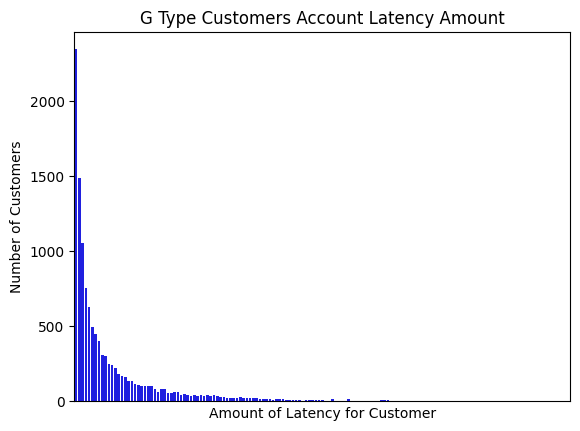

In [346]:
# created a data frame for bk account latency amount
bk_gecikmebakiye_df=scaled_gType_df['BK_GECIKMEBAKIYE'].value_counts().sort_index(ascending=True)

# visualizing it using seaborn library
sns.countplot(data=bk_gecikmebakiye_df, x=bk_gecikmebakiye_df.values, color='blue')
plt.xticks([])              # hide x-axis tick labels
plt.title('G Type Customers Account Latency Amount')
plt.xlabel('Amount of Latency for Customer')
plt.ylabel('Number of Customers')
plt.show()

In [347]:
scaled_gType_df['BK_ORAN'].value_counts().sort_index(ascending=True)

0.000000         27308
0.000169             1
0.000172             2
0.000315             8
0.000355             2
                 ...  
584100.000000        1
620000.000000        3
710920.000000        1
809550.000000        1
879000.000000        1
Name: BK_ORAN, Length: 117371, dtype: int64

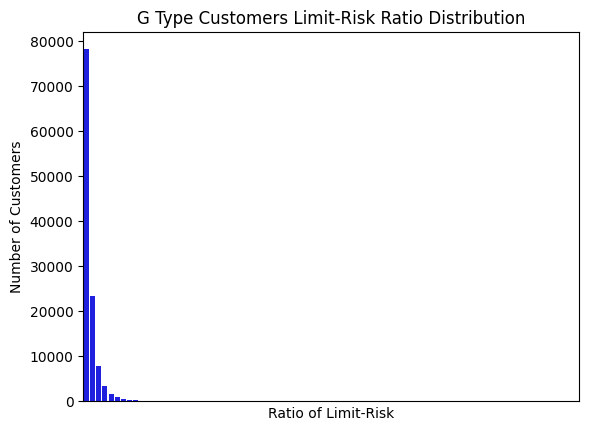

In [348]:
# created a data frame for bk ratio
bk_oran_df=scaled_gType_df['BK_ORAN'].value_counts().sort_index(ascending=True)
# visualizing it using seaborn library
sns.countplot(data=bk_oran_df, x=bk_oran_df.values, color='blue')
plt.xticks([])              # hide x-axis tick labels
plt.title('G Type Customers Limit-Risk Ratio Distribution')
plt.xlabel('Ratio of Limit-Risk')
plt.ylabel('Number of Customers')
plt.show()

In [349]:
scaled_gType_df['CEK_INCOME'].value_counts().sort_index(ascending=True)

0.000000e+00    43948
1.422610e+03        7
1.500000e+03        3
1.509000e+03        4
1.600000e+03        1
                ...  
8.152050e+05       28
9.089248e+05       29
1.005800e+06       32
1.101993e+06       25
1.218740e+06      243
Name: CEK_INCOME, Length: 8183, dtype: int64

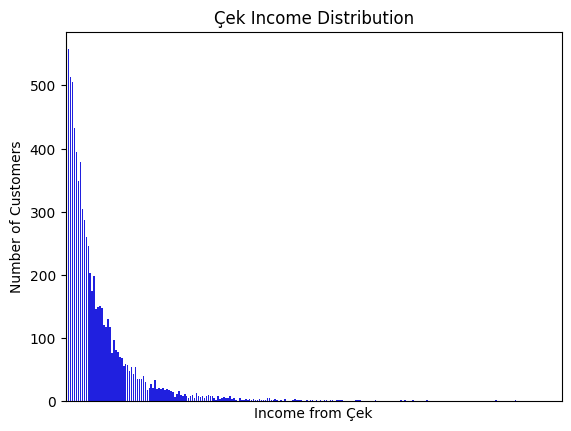

In [350]:
# created a data frame for customer income first
cek_income_df=scaled_gType_df['CEK_INCOME'].value_counts().sort_index(ascending=True)
# visualizing it using seaborn library
sns.countplot(data=cek_income_df, x=cek_income_df.values, color='blue', linewidth=2)
plt.xticks([])              # hide x-axis tick labels
plt.title('Çek Income Distribution')
plt.xlabel('Income from Çek')
plt.ylabel('Number of Customers')
plt.show()

As seen from distributions, there are many 0 values which may prevent the exact result of clustering. 0 values are imputed with mean values. To do this operation, it is significant to analyze the characteristics of the attributes:

* **BK_ORAN** shows the limit-risk ratio. we know that it is impossible to have 0 value both for limit and risk. so, when BK_ORAN is 0, then fill it with mean value of BK_ORAN column.
* **BK_GECIKMEHESAP** represents the number of accounts which has latency. If it is 0, this means there are no account with payment latency. So it is not possible to impute values of BK_GECIKMEHESAP. **We cannot change BK_GECIKMEBAKIYE as well.**

In [351]:
scaled_gType_df['BK_ORAN']= scaled_gType_df['BK_ORAN'].replace(0, scaled_gType_df['BK_ORAN'].mean())

C:\Users\emirh\AppData\Local\Temp\ipykernel_19932\1066422992.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_gType_df['BK_ORAN']= scaled_gType_df['BK_ORAN'].replace(0, scaled_gType_df['BK_ORAN'].mean())


>> Scaling the Data using Scikit-Learn Library

In [352]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()         # applying scaling

The main purpose of the logarithmic transformation is to reduce the impact of extreme values and compress the range of values in a more linear fashion. It accomplishes this by applying the natural logarithm function to the data, which tends to spread out the values and reduce the differences between large values.

Implementing logarithmic transformation below:

In [353]:
scaled_gType_data = scaled_gType_df.copy()

# applying logarithmic transformation
scaled_gType_data['BK_GECIKMEHESAP'] = np.log1p(scaled_gType_data['BK_GECIKMEHESAP'])
scaled_gType_data['BK_GECIKMEBAKIYE'] = np.log1p(scaled_gType_data['BK_GECIKMEBAKIYE'])
scaled_gType_data['BK_ORAN'] = np.log1p(scaled_gType_data['BK_ORAN'])
scaled_gType_data['CEK_INCOME'] = np.log1p(scaled_gType_data['CEK_INCOME'])
scaled_gType_data['BK_KURUMSAYISI'] = np.log1p(scaled_gType_data['BK_KURUMSAYISI'])
scaled_gType_data['KESIDECI_COUNT'] = np.log1p(scaled_gType_data['KESIDECI_COUNT'])
scaled_gType_data['SUBE_COUNT'] = np.log1p(scaled_gType_data['SUBE_COUNT'])

In [354]:
scaled_gType_data[['BK_GECIKMEBAKIYE', 'BK_GECIKMEHESAP','BK_ORAN', 'CEK_INCOME','BK_KURUMSAYISI','KESIDECI_COUNT','SUBE_COUNT']] = scaler.fit_transform(scaled_gType_data[['BK_GECIKMEBAKIYE', 'BK_GECIKMEHESAP','BK_ORAN', 'CEK_INCOME','BK_KURUMSAYISI','KESIDECI_COUNT','SUBE_COUNT']])

In [355]:
scaled_gType_data.head(5)

,CEK_INCOME,BK_GECIKMEBAKIYE,BK_GECIKMEHESAP,BK_KURUMSAYISI,BK_ORAN,KESIDECI_COUNT,SUBE_COUNT
0,0.772818,0.000000,0.000000,0.000000,0.504188,0.170707,0.442507
1,0.772108,0.471287,0.316993,0.500000,0.173796,0.225663,0.000000
2,0.772818,0.000000,0.000000,0.000000,0.504188,0.170707,0.442507
3,0.858592,0.557181,0.400000,0.396241,0.136698,0.225663,0.000000
4,0.000000,0.566973,0.400000,0.750000,0.061653,0.225663,0.000000


In [356]:
scaled_gType_data.describe()    # to check whether the scaling is done or not by controlling the min and max values as 0 and 1

,CEK_INCOME,BK_GECIKMEBAKIYE,BK_GECIKMEHESAP,BK_KURUMSAYISI,BK_ORAN,KESIDECI_COUNT,SUBE_COUNT
count,229538.000000,229538.000000,229538.000000,229538.000000,229538.000000,229538.000000,229538.000000
mean,0.649977,0.320846,0.239149,0.449655,0.142247,0.347113,0.007795
std,0.323036,0.245613,0.201312,0.223901,0.169115,0.228156,0.058759
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.686195,0.000000,0.000000,0.250000,0.058492,0.170707,0.000000
50%,0.787458,0.419281,0.200000,0.500000,0.069041,0.341415,0.000000
75%,0.848595,0.529513,0.400000,0.580482,0.098072,0.512122,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [357]:
# selecting the input columns for clustering
feature_columns_g_Type = ['BK_ORAN', 'BK_GECIKMEHESAP', 'BK_GECIKMEBAKIYE','CEK_INCOME',
                    'KESIDECI_COUNT','SUBE_COUNT','One Timer','Very Often','Often','Rare']

In [358]:
# now append scaled versions into main dataframe
g_company_type= g_company_type_df.copy()
g_company_type[['BK_GECIKMEBAKIYE', 'BK_GECIKMEHESAP','BK_ORAN', 'CEK_INCOME','BK_KURUMSAYISI','KESIDECI_COUNT','SUBE_COUNT']] = scaled_gType_data[['BK_GECIKMEBAKIYE', 'BK_GECIKMEHESAP','BK_ORAN', 'CEK_INCOME','BK_KURUMSAYISI','KESIDECI_COUNT','SUBE_COUNT']]

In [359]:
# deleting unused attributes for ML
del g_company_type['ID']

In [360]:
g_company_type.set_index('MUSTERI_ID', inplace=True)
g_company_type.head(10)

,BK_KURUMSAYISI,BK_GECIKMEHESAP,BK_GECIKMEBAKIYE,BK_ORAN,KESIDECI_COUNT,SUBE_COUNT,CEK_INCOME,One Timer,Very Often,Often,Rare
MUSTERI_ID,,,,,,,,,,,
11800527,0.000000,0.000000,0.000000,0.504188,0.170707,0.442507,0.772818,0,0,1,0
12024009,0.500000,0.316993,0.471287,0.173796,0.225663,0.000000,0.772108,1,0,0,0
11800527,0.000000,0.000000,0.000000,0.504188,0.170707,0.442507,0.772818,0,0,1,0
11724283,0.396241,0.400000,0.557181,0.136698,0.225663,0.000000,0.858592,0,1,0,0
11879266,0.750000,0.400000,0.566973,0.061653,0.225663,0.000000,0.000000,0,0,1,0
11879266,0.750000,0.400000,0.566973,0.061653,0.225663,0.000000,0.000000,0,0,1,0
11854083,0.000000,0.000000,0.000000,0.504188,0.579093,0.000000,0.878577,0,1,0,0
11654711,0.580482,0.200000,0.459180,0.064837,0.000000,0.000000,0.000000,1,0,0,0
11723432,0.580482,0.400000,0.535266,0.069556,0.225663,0.000000,0.657263,0,0,1,0


> Elbow Method

We aim to maximize the efficiency of segmentation while minimizing the number of clusters. In this sense, Elbow Method is crucial concept to satisfy this requirement.

In [361]:
# importing scikit-learning library for the K-means model
from sklearn.cluster import KMeans

Declare the Elbow Method function here

In [362]:
def find_optimal_clusters(df, maximum_K):
    clusters_centers = []   # appending inertia value coming from the model
    k_values = []           # putting k values from 0 to maximum K

    for k in range(1, maximum_K):
        kmeans_model = KMeans(n_clusters = k)
        kmeans_model.fit(df)

        clusters_centers.append(kmeans_model.inertia_)
        k_values.append(k)

    return clusters_centers, k_values

*Note About **Inertia***:

Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster. **A good model is one with low inertia** and **a low number of clusters** (K) *-Codeacademy*

In the next step, illustrating an elbow method for the data using a function

In [363]:
def generate_elbow_plot(clusters_centers, k_values):
    figure = plt.subplots(figsize = (12, 6))
    plt.plot(k_values, clusters_centers, 'o-', color = 'blue')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Cluster Inertia")
    plt.title("Elbow Plot of Model")
    plt.show()

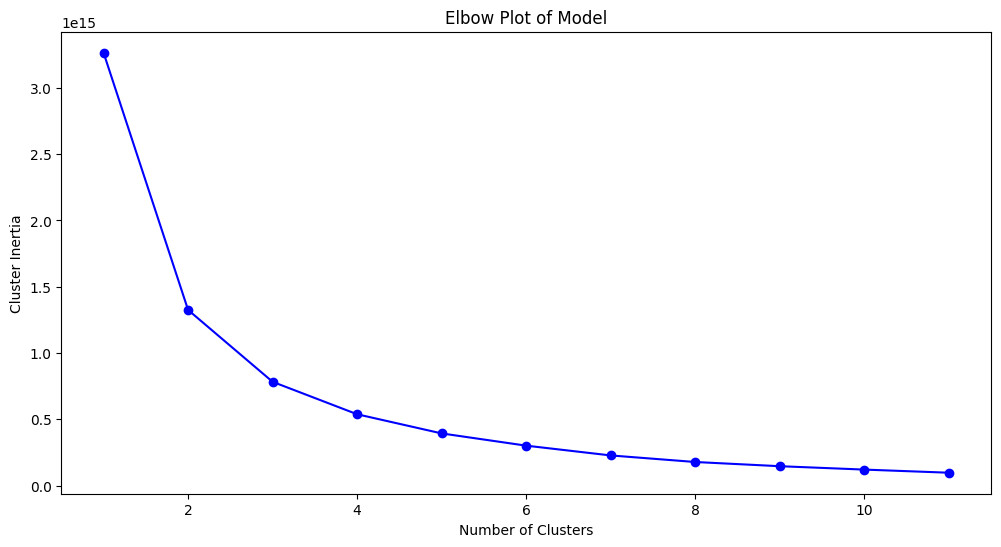

In [364]:
clusters_centers, k_values = find_optimal_clusters(g_company_type_df[feature_columns_g_Type], 12)
generate_elbow_plot(clusters_centers, k_values)

> Putting Into K-means Model

There may be multiple customer records. To prevent this issue, we are grouping by their records' mean values.

In [365]:
# group customers by average before putting into model
# because there may be multiple transactions for a customer
g_company_type = g_company_type.groupby('MUSTERI_ID').mean()

In [281]:
g_company_type.tail(10)

,BK_KURUMSAYISI,BK_GECIKMEHESAP,BK_GECIKMEBAKIYE,BK_ORAN,KESIDECI_COUNT,SUBE_COUNT,CEK_INCOME,One Timer,Very Often,Often,Rare
MUSTERI_ID,,,,,,,,,,,
300186750,0.646241,0.400000,0.559447,0.056484,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0
300186821,0.864858,0.691886,0.673459,0.101573,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0
300187030,0.580482,0.422961,0.646689,0.061699,0.527052,0.0,0.796118,0.0,1.0,0.0,0.0
300187267,0.646241,0.576883,0.599379,0.070250,0.099857,0.0,0.772108,0.0,1.0,0.0,0.0
300187284,0.701839,0.316993,0.499855,0.065400,0.099857,0.0,0.000000,1.0,0.0,0.0,0.0
300187361,0.701839,0.600000,0.629150,0.083671,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0
300187364,0.569984,0.505470,0.568554,0.078222,0.225663,0.0,0.865470,0.0,1.0,0.0,0.0
300187387,0.587058,0.356634,0.365593,0.061836,0.341415,0.0,0.711883,0.0,1.0,0.0,0.0
300188314,0.580482,0.200000,0.573240,0.061726,0.099857,0.0,0.722646,0.0,0.0,1.0,0.0


In [367]:
g_kmeans = KMeans(n_clusters=4)       # initialize the k-means model by using the optimal number of clusters found in the elbow method
g_kmeans.fit = g_kmeans.fit(g_company_type)          # fit the k-means model to the data

g_company_type['cluster_labels'] = g_kmeans.labels_      # assign cluster labels to the original DataFrame

In [368]:
g_company_type['cluster_labels'].value_counts()

1    15008
0    13739
2     7598
3     2029
Name: cluster_labels, dtype: int64

In [369]:
# append cluster labels from g_company_type to the original DataFrame named g_company_type_df
# merge them using common ID named MUSTERI_ID
g_company_type_df = pd.merge(g_company_type_df, g_company_type[['cluster_labels']], on='MUSTERI_ID')
g_company_type_df.head(10)

,ID,MUSTERI_ID,BK_KURUMSAYISI,BK_GECIKMEHESAP,BK_GECIKMEBAKIYE,BK_ORAN,KESIDECI_COUNT,SUBE_COUNT,CEK_INCOME,One Timer,Very Often,Often,Rare,cluster_labels
0,2457932,11800527,0,0.0,0.0,0.000000,3,2,50500.0,0,0,1,0,2
1,2457934,11800527,0,0.0,0.0,0.000000,3,2,50500.0,0,0,1,0,2
2,2664562,11800527,0,0.0,0.0,0.000000,3,2,50500.0,0,0,1,0,2
3,2691481,11800527,0,0.0,0.0,0.000000,3,2,50500.0,0,0,1,0,2
4,2908087,11800527,0,0.0,0.0,0.000000,3,2,50500.0,0,0,1,0,2
5,2928438,11800527,0,0.0,0.0,0.000000,3,2,50500.0,0,0,1,0,2
6,2457933,12024009,3,2.0,1012.0,9.792035,4,1,50000.0,1,0,0,0,1
7,2457954,12024009,3,2.0,1012.0,9.792035,4,1,50000.0,1,0,0,0,1
8,2458651,12024009,3,2.0,1012.0,9.792035,4,1,50000.0,1,0,0,0,1
9,2458652,12024009,3,2.0,1012.0,9.792035,4,1,50000.0,1,0,0,0,1


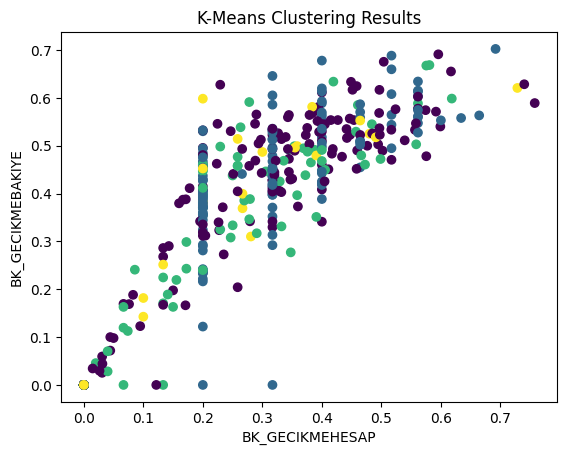

In [370]:
g_company_type_sample = g_company_type.sample(500)     # sample 500 customers from the dataset
scatter=plt.scatter(g_company_type_sample['BK_GECIKMEHESAP'], g_company_type_sample['BK_GECIKMEBAKIYE'],
            c=g_company_type_sample['cluster_labels'])

plt.xlabel('BK_GECIKMEHESAP')
plt.ylabel('BK_GECIKMEBAKIYE')
plt.title('K-Means Clustering Results')
plt.show()